Simulates carbon dephasing under perfect repumping conditions but with imperfect initialization and MW pulses

In [255]:
execfile(r'D:\measuring\analysis\scripts\setup_analysis.py')
%matplotlib inline

reloaded


In [173]:
## now try to speed up the code by making the RNG array 3D.
LDE_attempts = averages = 20
rngs_init = np.random.rand(LDE_attempts,averages)
rngs_mw = np.random.rand(LDE_attempts,averages)

def generate_error_vectors(init_infidelity = 0.003,mw_infidelity=0.01):
    ### state vector of the electron spin after initialization
    e_init = np.array([1-init_infidelity,1-init_infidelity/2.,1])
    ### state dependent MW action
    e_MW = np.array([1-mw_infidelity,1.]) ### need special case for being in -1? It is only a second order effect.
    return e_init,e_MW

def find_e_state_phase_cofficients(rngs_init,rngs_mw,e_init,e_MW):
    ## let's do 5 trials of the experiment and make numpy comparisons to weed out the electron state.
    e_in0 = rngs_init < e_init[0]
    e_inm1 = (e_init[0]< rngs_init) & (rngs_init < e_init[1])
    e_inp1 = np.logical_not(np.logical_or(e_in0,e_inm1))
    mw_failed = rngs_mw > e_MW[0]
    mw_m1 = np.logical_not(e_inp1)*mw_failed*e_inm1
    mw_0 = np.logical_not(e_inp1)*mw_failed*e_in0
    return e_inm1,e_inp1,mw_m1,mw_0
    
def get_errs(rngs_init,rngs_mw,**kw):
    e_init,e_MW = generate_error_vectors(**kw)
    return find_e_state_phase_cofficients(rngs_init,rngs_mw,e_init,e_MW)

def calc_phase_distribution(e_inm1,e_inp1,mw_m1,mw_0,coupling_strength):
    decoupling_duration = 2.25 #us
    inittodecouplingduration = 3.0 #us    
    init_phase_e_inp1 = coupling_strength*inittodecouplingduration*1e-6
    init_phase_e_inm1 = -init_phase_e_inp1
    
    
    ## we assume that the used MW transition is 0 <--> -1
    mw_phase_e_in0 = -decoupling_duration*coupling_strength*1e-6
    mw_phase_e_inm1 = -mw_phase_e_in0
    mw_phase_e_inp1 = 1.5*2*decoupling_duration*coupling_strength*1e-6
    ## let's do 5 trials of the experiment and make numpy comparisons to weed out the electron state.
    
    acquired_phase_per_trial = np.zeros(np.shape(e_inm1))
    acquired_phase_per_trial = acquired_phase_per_trial + e_inm1*init_phase_e_inm1 + e_inp1*(init_phase_e_inp1+mw_phase_e_inp1)
    acquired_phase_per_trial = acquired_phase_per_trial + mw_0*mw_phase_e_in0+mw_m1*mw_phase_e_inm1
    return acquired_phase_per_trial*2*np.pi    

In [352]:
#idea of the code above is that we only have to generate the RNDs once and then can reuse them.

LDE_attempts = 2000
averages = 800 #### how often to perform the 'experiment'
rngs_init = np.random.rand(LDE_attempts,averages)
rngs_mw = np.random.rand(LDE_attempts,averages)


In [353]:
mw_infidelity = 0.01; init_infidelity = 0.0005
e_inm1,e_inp1,mw_m1,mw_0 = get_errs(rngs_init,rngs_mw,init_infidelity=init_infidelity,mw_infidelity = mw_infidelity)
a=calc_phase_distribution(e_inm1,e_inp1,mw_m1,mw_0,40e3)

In [354]:
### now for several couplingg strenghts
def calc_fidelity_decay(phase_distribution):
    return (np.average(np.cos(np.cumsum(phase_distribution,axis=0)),axis=1)+1.)/2.
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [365]:
## specifically interested in the behaviour of the 1/e value of all of these curves
couplings = np.arange(5,40,2)*1e3
decay_const = []
for c in couplings:
    decay_const.append(find_nearest(calc_fidelity_decay(calc_phase_distribution(e_inm1,e_inp1,mw_m1,mw_0,c)),0.5+0.5/np.exp(1)))

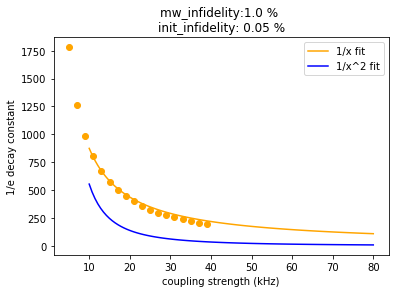

In [366]:
p0,fitfunc,fitfunc_str = common.fit_hyperbola(20,1,0)
fit_resx = fit.fit1d(couplings*1e-3,np.array(decay_const),None,p0=p0,fitfunc=fitfunc,fixed=[1,2],do_print=False)
fit_x = np.linspace(10,80,100)
plt.plot(fit_x,fit_resx['fitfunc'](fit_x),'-',label = '1/x fit',color='orange')
p0,fitfunc,fitfunc_str = common.fit_hyperbola(20,2,0)
fit_resx2 = fit.fit1d(couplings*1e-3,np.array(decay_const),None,p0=p0,fitfunc=fitfunc,fixed=[1,2],do_print=False)
plt.plot(fit_x,fit_resx2['fitfunc'](fit_x),'-',label = '1/x^2 fit',color='blue')
plt.plot(couplings*1e-3,decay_const,'o',color = 'orange')
plt.xlabel('coupling strength (kHz)')
plt.ylabel('1/e decay constant')
plt.title('mw_infidelity:' + str(mw_infidelity*100) + ' % \n' 'init_infidelity: ' + str(init_infidelity*100)+ ' %')
plt.legend()
plt.show()

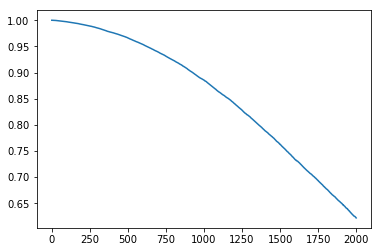

In [372]:
## plot the decay around 450 kHz
plt.plot(calc_fidelity_decay(calc_phase_distribution(e_inm1,e_inp1,mw_m1,mw_0,5e3)))
### produces oscillations and the typical quasi gaussian signal that we observe with LT4.